In [1]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 253.3MB 101kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x4eba4000 @  0x7f07c3f111c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [5]:
!pip install pandas
!pip install datetime
!pip install matplotlib
!pip install sklearn
!pip install keras
!pip install cuda

  Could not find a version that satisfies the requirement cuda (from versions: )
No matching distribution found for cuda


In [4]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
import lstm, time 
import numpy as np
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import  MaxPooling1D

Using TensorFlow backend.


ImportError: ignored

This is a model to simulate the fisheries interaction, we uses oceanographic data, economical data, to forecast the catch for each fisheries in the  Souther Baja California State in Mexico. 
The data are set as follow:


In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
#importacion de los datos
dataset = read_csv('data.csv', header=0, index_col=0)
print(dataset.shape)

In [0]:
values = dataset.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,:1])



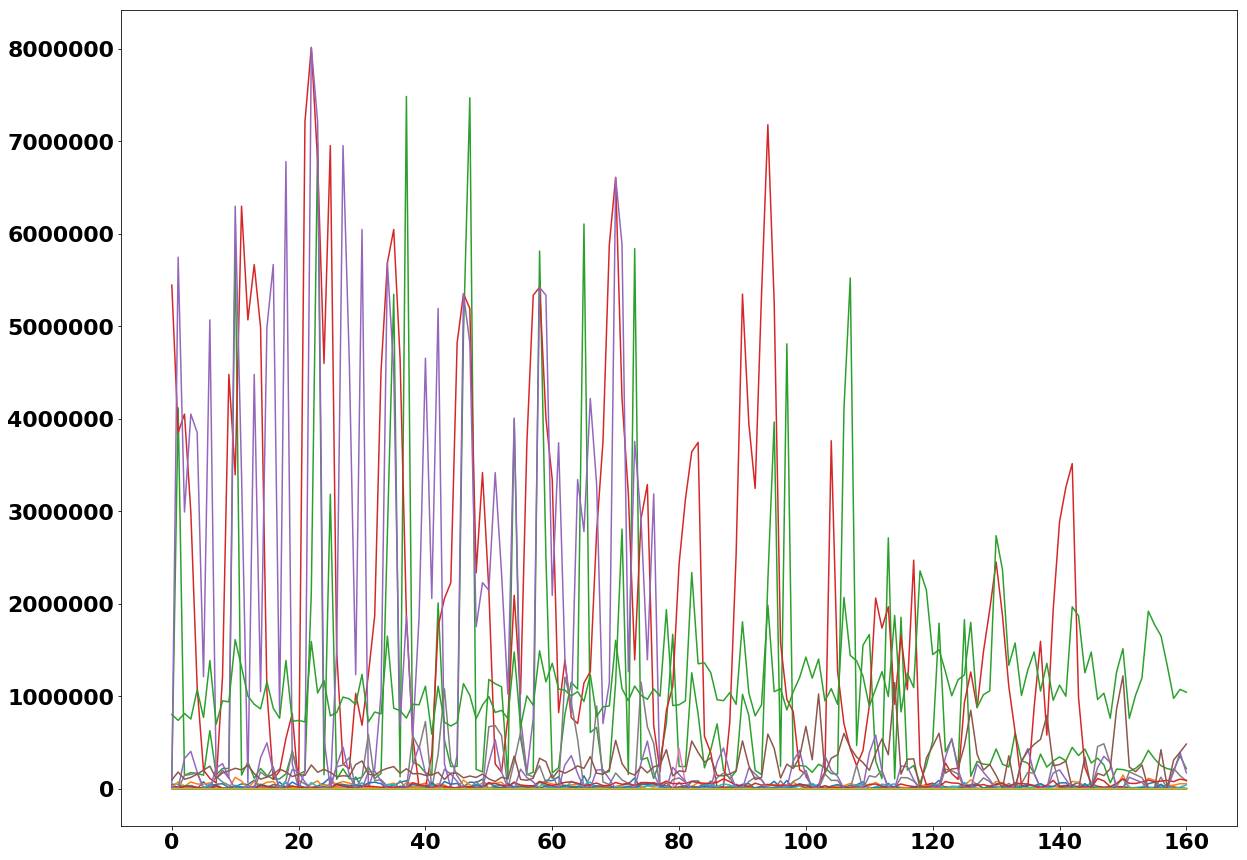

In [0]:
pyplot.figure(figsize=(20,15))
pyplot.plot(dataset.values[:,:])
pyplot.savefig('todos.png')
#print(dataset.values[:,:1])

In [0]:
# nos aseguramos de que todos los datos esten en formato numerico con punto 
#flotante de 32 ceros
values = values.astype('float32')
print(values.shape)

(161, 19)


In [0]:
# normalizamos los datos 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#se aplica el delay
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True) 

In [0]:
#print(reframed.shape)

In [0]:
# se dividen los datos en conjunto de entrenamiento y en conjunto de test
values = reframed.values
n_train_hours = 132-12#aquí divido asígno el numero de datos para test
train = values[:n_train_hours, :]#aquí separo los datos para el entrenamiento
test = values[n_train_hours:, :]#los datos para el test
#print(values.shape,train.shape,test.shape)
# split into input and outputs
train_X = train[:, :]
train_y = train[:,:16 ]#aquí seleccionas el vector correspondiente a pronóstico
test_X=  test[:, :]
test_y = test[:, :16]#idem
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


print(test_X.shape)


(40, 1, 36)


No handles with labels found to put in legend.


36


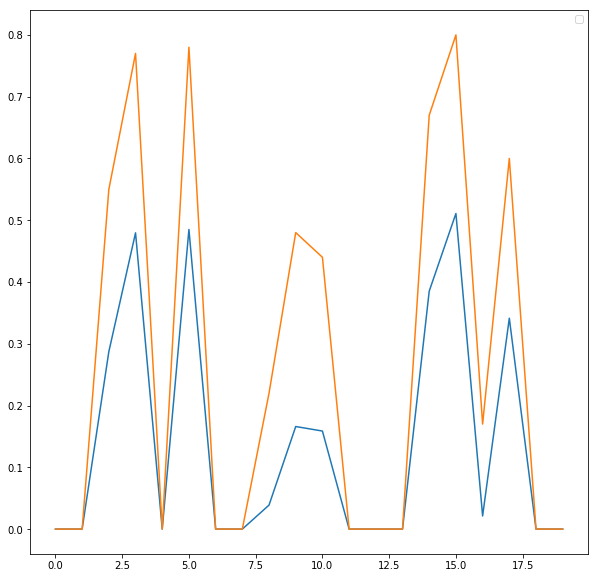

In [0]:
pyplot.figure(figsize=(10,10))
pyplot.plot(values[140:,:1])
pyplot.plot(values[140:,1:2])
pyplot.legend()
print(test_X.shape[2])


In [0]:
# design network
model = Sequential()
model.add(LSTM(150,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('linear'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Dense(16))
model.add(LSTM(150,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Activation('linear'))
model.add(Dense(16))
model.compile(loss='mae', optimizer='adamax')





In [0]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=500, batch_size=5,validation_data=(test_X, test_y),shuffle=False)


Train on 120 samples, validate on 40 samples
Epoch 1/500
120/120 [==============================] - 34s 281ms/step - loss: 0.2037 - val_loss: 0.1740
Epoch 2/500
120/120 [==============================] - 1s 7ms/step - loss: 0.1750 - val_loss: 0.1521
Epoch 3/500
120/120 [==============================] - 1s 6ms/step - loss: 0.1648 - val_loss: 0.1477
Epoch 4/500
120/120 [==============================] - 1s 6ms/step - loss: 0.1608 - val_loss: 0.1462
Epoch 5/500
120/120 [==============================] - 1s 6ms/step - loss: 0.1587 - val_loss: 0.1451
Epoch 6/500
120/120 [==============================] - 1s 5ms/step - loss: 0.1576 - val_loss: 0.1440
Epoch 7/500
120/120 [==============================] - 1s 6ms/step - loss: 0.1567 - val_loss: 0.1429
Epoch 8/500
120/120 [==============================] - 1s 7ms/step - loss: 0.1558 - val_loss: 0.1429
Epoch 9/500
120/120 [==============================] - 1s 7ms/step - loss: 0.1529 - val_loss: 0.1426
Epoch 10/500
120/120 [=====================

In [0]:
#print(inv_y.reshape(22,1))
#print(inv_yhat.reshape(22,1))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 150)            112200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 150)            0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 150)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 150)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             2416      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 150)            100200    
__________

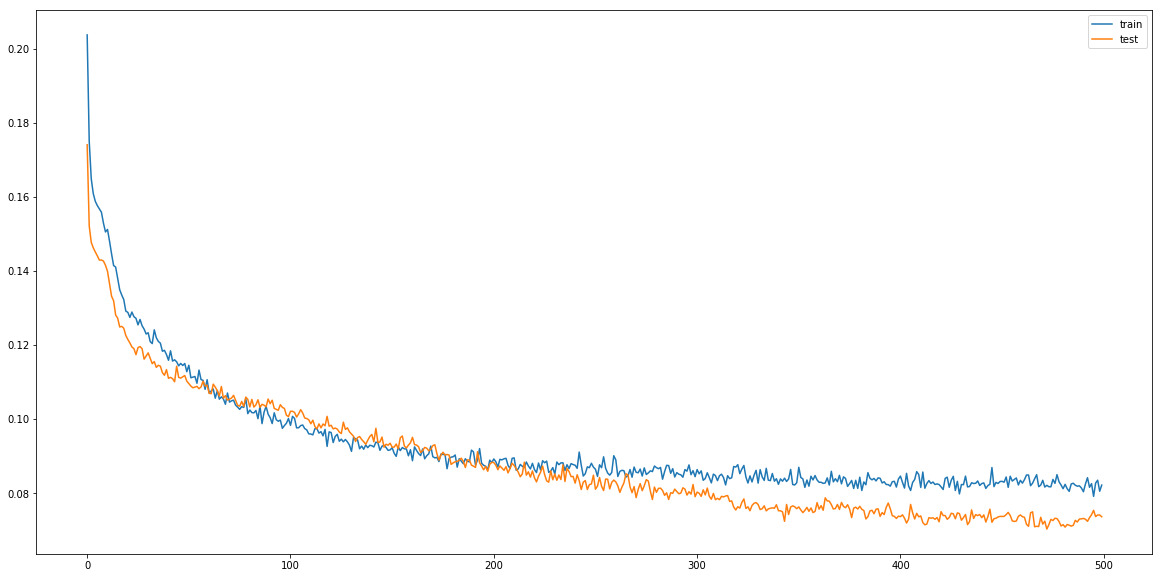

In [0]:
pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
 #make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, :3]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat)
inv_yhat3 = inv_yhat2[:,]
# invert scaling for actual
test_y2 = test_y.reshape((len(test_y), 16))
inv_y = np.concatenate((test_y2, test_X[:, :3]), axis=1)
inv_y2 = scaler.inverse_transform(inv_y)
inv_y3 = inv_y2[0:40,:]

In [0]:
resul=DataFrame(inv_y3)
resul.to_csv('real_test.csv')

In [0]:
prono=DataFrame(inv_yhat3)
prono.to_csv('pronostico.csv')

In [0]:
R=np.array(np.linspace(0,15,15))
RMSE=np.array(np.linspace(0,15,15))
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr

# calculate RMSE

for i in range(1,16):
    a=i
    r=pearsonr(inv_y3[:,a-1:a], inv_yhat3[:,a-1:a])
    rmse= np.sqrt(mean_squared_error(inv_y3[:,a-1:a], inv_yhat3[:,a-1:a]))
    R[i-1]=r[0]
    RMSE[i-1]=rmse
    print('Test RMSE: %.0f' % rmse)
    print('Test R %.5f' %r[0])


Test RMSE: 7310
Test R 0.97417
Test RMSE: 9
Test R 0.97173
Test RMSE: 360108
Test R 0.46191
Test RMSE: 641612
Test R 0.94583
Test RMSE: 4349
Test R nan
Test RMSE: 5155
Test R 0.68063
Test RMSE: 14549
Test R 0.52298
Test RMSE: 120831
Test R 0.94060
Test RMSE: 6640
Test R 0.98678
Test RMSE: 2084
Test R -0.38736
Test RMSE: 11994
Test R 0.74986
Test RMSE: 5549
Test R 0.79044
Test RMSE: 288492
Test R 0.88029
Test RMSE: 23139
Test R 0.37594
Test RMSE: 72525
Test R 0.95515


In [0]:
R=DataFrame(R)
R.to_csv('R.csv')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)
pyplot.subplot(221)
pyplot.plot(inv_y3[:,0:1], label='y')
pyplot.plot(inv_yhat3[:,0:1], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('ABULON ')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,0:1],inv_yhat3[:,0:1],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)

pyplot.subplot(222)
pyplot.plot(inv_y3[:,1:2], label='y')
pyplot.plot(inv_yhat3[:,1:2], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('ALGAS')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,1:2],inv_yhat3[:,1:2],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)


pyplot.savefig('simulacion1.png')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)
pyplot.subplot(221)
pyplot.plot(inv_y3[:,2:3], label='y')
pyplot.plot(inv_yhat3[:,2:3], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('ALMEJAS')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,2:3],inv_yhat3[:,2:3],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)

pyplot.subplot(222)
pyplot.plot(inv_y3[:,3:4], label='y')
pyplot.plot(inv_yhat3[:,3:4], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('CALAMAR')
pyplot.grid(True)
pyplot.legend()


pyplot.subplot(224)
pyplot.plot(inv_y3[:,3:4],inv_yhat3[:,3:4],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion2.png')

In [0]:
pyplot.figure(figsize=(25,12))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)

pyplot.subplot(221)
pyplot.plot(inv_y3[:,4:5], label='y')
pyplot.plot(inv_yhat3[:,4:5], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('CALLO')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,4:5],inv_yhat3[:,4:5],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)

pyplot.subplot(222)
pyplot.plot(inv_y3[:,5:6], label='y')
pyplot.plot(inv_yhat3[:,5:6], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('CAMARON')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,5:6],inv_yhat3[:,5:6],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion3.png')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)

pyplot.subplot(221)
pyplot.plot(inv_y3[:,6:7], label='y')
pyplot.plot(inv_yhat3[:,6:7], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('CANGREJO')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,6:7],inv_yhat3[:,6:7],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)

pyplot.subplot(222)
pyplot.plot(inv_y3[:,7:8], label='y')
pyplot.plot(inv_yhat3[:,7:8], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('CARACOL')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,7:8],inv_yhat3[:,7:8],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion4.png')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)

pyplot.subplot(221)
pyplot.plot(inv_y3[:,8:9], label='y')
pyplot.plot(inv_yhat3[:,8:9], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('DEPORTIVAS')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,8:9],inv_yhat3[:,8:9],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)


pyplot.subplot(222)
pyplot.plot(inv_y3[:,9:10], label='y')
pyplot.plot(inv_yhat3[:,9:10], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('ERIZO')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,9:10],inv_yhat3[:,9:10],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)

pyplot.savefig('simulacion5.png')



In [0]:
pyplot.figure(figsize=(20,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)

pyplot.subplot(221)
pyplot.plot(inv_y3[:,10:11], label='y')
pyplot.plot(inv_yhat3[:,10:11], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('ESCAMA')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,10:11],inv_yhat3[:,10:11],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)


pyplot.subplot(222)
pyplot.plot(inv_y3[:,11:12], label='y')
pyplot.plot(inv_yhat3[:,11:12], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('JAIBA')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,11:12],inv_yhat3[:,11:12],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion6.png')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)
pyplot.subplot(221)
pyplot.plot(inv_y3[:,12:13], label='y')
pyplot.plot(inv_yhat3[:,12:13], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('LANGOSTA')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,12:13],inv_yhat3[:,12:13],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)


pyplot.subplot(222)
pyplot.plot(inv_y3[:,13:14], label='y')
pyplot.plot(inv_yhat3[:,13:14], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('OTROS')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,13:14],inv_yhat3[:,13:14],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion8.png')

In [0]:
pyplot.figure(figsize=(25,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

pyplot.rc('font',**font)

pyplot.subplot(221)
pyplot.plot(inv_y3[:,14:15], label='y')
pyplot.plot(inv_yhat3[:,14:15], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('TIBURONES')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(223)
pyplot.plot(inv_y3[:,14:15],inv_yhat3[:,14:15],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)


pyplot.subplot(222)
pyplot.plot(inv_y3[:,15:16], label='y')
pyplot.plot(inv_yhat3[:,15:16], label='yhat')
pyplot.ylabel('Kg')
pyplot.xlabel('meses')
pyplot.title('TUNIDOS')
pyplot.grid(True)
pyplot.legend()

pyplot.subplot(224)
pyplot.plot(inv_y3[:,15:16],inv_yhat3[:,15:16],'bo')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.grid(True)
pyplot.savefig('simulacion7.png')

In [0]:
pyplot.figure(figsize=(15,12))
pyplot.subplot(221)
pyplot.plot(inv_y3[:,16:])

pyplot.xlabel('meses')

pyplot.grid(True)
pyplot.legend()

In [0]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


print(inv_y3[:0:1].shape)
x=np.array(DataFrame(inv_y3[:,0:1]))
y=np.array(DataFrame(inv_yhat3[:,0:1]))
regr = linear_model.LinearRegression()
regr.fit(x, y)
y_pred = regr.predict(x)

print(y_pred)
pyplot.figure(figsize=(12 ,15))
pyplot.plot(inv_y3[:,0:1],inv_yhat3[:,0:1],'bo')
pyplot.plot(y_pred,'r-')
pyplot.ylabel('y')
pyplot.xlabel('yhat')
pyplot.title('ABULON')
pyplot.grid(True)


